In [1]:
import torch as t
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Model

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(3*32*32, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 3*32*32)
        x = self.relu(self.linear1(x))
        return x
net = Net()



### Hyperparams

In [50]:
batch_size=128
num_epochs=200
num_batches=100
loss_fn = nn.CrossEntropyLoss()
opti = 'SGD'
LR = 0.01
optimizer = t.optim.SGD(net.parameters(), lr=LR)

In [51]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

mnist_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
train_loader.dataset[0][1]

6

### Training

In [53]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    c = 0

    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        # data.shape=torch.Size([10, 3, 32, 32]) --> 10 images,labels
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs.view(-1, 3*32*32))


        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % num_batches == num_batches-1:
            last_loss = running_loss / num_batches # loss per num_batches batches
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

### Evaluate

In [54]:
def test(model, loader):
  total=0
  correct=0
  model.eval()
  with t.no_grad():
      for data in loader:
          x, y = data
          output = model(x.view(-1, 3*32*32))
          for idx, i in enumerate(output):
              if t.argmax(i) == y[idx]:
                  correct +=1
              total +=1
  return round(correct/total, 3)*100

In [55]:
epoch_number = 0

losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    avg_loss = train_one_epoch(epoch_number)
    losses.append(avg_loss)

    # Train accuracy
    train_acc = test(net, train_loader)
    train_accuracy.append(train_acc)

    # Test accuracy
    test_acc = test(net, test_loader)
    test_accuracy.append(test_acc)

    print('Train accuracy {}:'.format(train_acc))
    print('Test accuracy {}:'.format(test_acc))

    epoch_number += 1

EPOCH 1:
 batch 100 loss: 2.0320737850666046
 batch 200 loss: 1.8883456885814667
 batch 300 loss: 1.8422425210475921
Train accuracy 39.0:
Test accuracy 38.1:
EPOCH 2:
 batch 100 loss: 1.8031817030906678
 batch 200 loss: 1.7809793603420259
 batch 300 loss: 1.7733549785614013
Train accuracy 40.5:
Test accuracy 39.300000000000004:
EPOCH 3:
 batch 100 loss: 1.7587704586982726
 batch 200 loss: 1.7573637890815734
 batch 300 loss: 1.7573568153381347
Train accuracy 41.8:
Test accuracy 40.400000000000006:
EPOCH 4:
 batch 100 loss: 1.7266524732112885
 batch 200 loss: 1.737440618276596
 batch 300 loss: 1.7340719258785249
Train accuracy 42.3:
Test accuracy 40.8:
EPOCH 5:
 batch 100 loss: 1.731724463701248
 batch 200 loss: 1.7306292581558227
 batch 300 loss: 1.7246165800094604
Train accuracy 42.5:
Test accuracy 40.6:
EPOCH 6:
 batch 100 loss: 1.7258873522281646
 batch 200 loss: 1.714793211221695
 batch 300 loss: 1.7036162507534027
Train accuracy 42.699999999999996:
Test accuracy 41.099999999999994:

### Plotting

In [56]:
import numpy as np
epochs_arr = np.arange(0, len(losses))

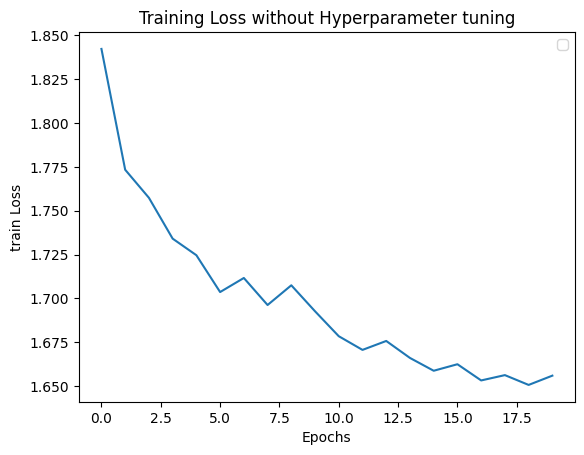

In [57]:
# Plot training loss
xpoints = np.array(epochs_arr)
ypoints = np.array(losses)

plt.plot(xpoints, ypoints)
plt.xlabel("Epochs")
plt.ylabel("train Loss")
plt.legend()
plt.title('Training Loss without Hyperparameter tuning')
plt.show()

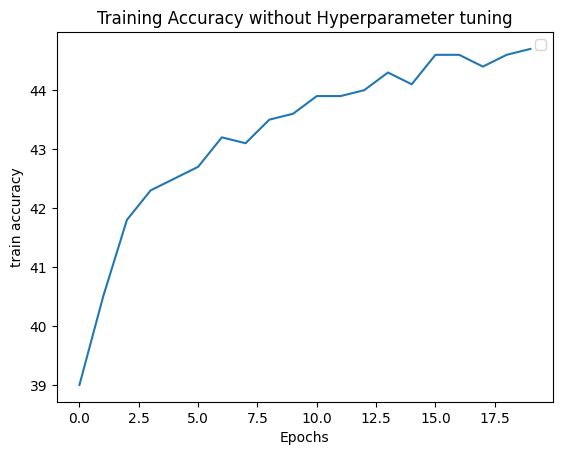

In [58]:
# Plot training accuracy
xpoints = np.array(epochs_arr)
ypoints = np.array(train_accuracy)

plt.plot(xpoints, ypoints)
plt.xlabel("Epochs")
plt.ylabel("train accuracy")
plt.legend()
plt.title('Training Accuracy without Hyperparameter tuning')
plt.show()

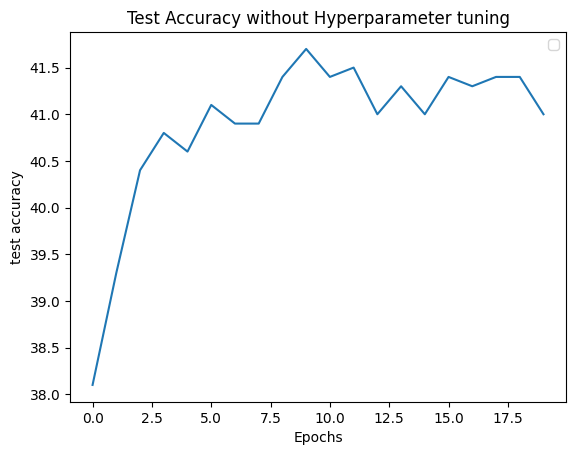

In [59]:
# Plot test accuracy
xpoints = np.array(epochs_arr)
ypoints = np.array(test_accuracy)

plt.plot(xpoints, ypoints)
plt.xlabel("Epochs")
plt.ylabel("test accuracy")
plt.legend()
plt.title('Test Accuracy without Hyperparameter tuning')
plt.show()

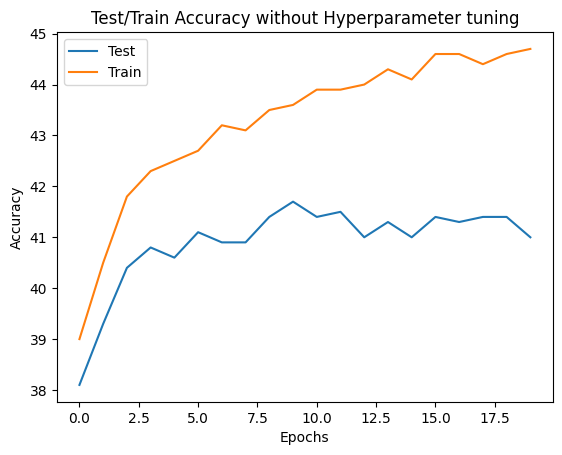

In [60]:
# Plot accuracy
xpoints = np.array(epochs_arr)
ypoints_test = np.array(test_accuracy)
ypoints_train = np.array(train_accuracy)
plt.plot(xpoints, ypoints_test, label='Test')
plt.plot(xpoints, ypoints_train, label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Test/Train Accuracy without Hyperparameter tuning')
plt.show()

### Save model

In [61]:
from google.colab import drive
drive.mount('/content/drive/')
import datetime as dt
ts_now = dt.datetime.now()
unix_timestamp = dt.datetime.timestamp(ts_now)*1000
model_save_name = str(unix_timestamp)
path = F"/content/drive/MyDrive/Ell409/CIFAR/{model_save_name}_bs{batch_size}_e{num_epochs}_{opti}_LR=0.01_mnist.pt"
t.save(net.state_dict(), path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
model_save_name = '1694017804212.393.pt'
path = F"/content/drive/MyDrive/Ell409/{model_save_name}"
net.load_state_dict(t.load(path))

In [ ]:
test(net,test_loader)